# COVID 19 Severity Prediction  
**Goal**: For a given individual who is diagnosed with COVID 19 we want to determine the severity of their infection in terms of the probability of decease and probability of ICU admittance.  
**Dataset**: The dataset available to us is curated by the Mexico Government and contains information for 500k+ observations. It contains information regarding the result of the test, time of detection, demographic information and most importantly that of various health conditions.  

## Data Preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import and asses dataset
# Dataset description can be found at: https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset?select=covid.csv
df = pd.read_csv("../data/mexico_government_covid19_patient/covid.csv")
print(df.shape)
df.head()

(566602, 23)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


If the date_died is invalid then the given case of COVID 19 did not result in fatality. So we form a new feature "lethal" indicating this. All invalid dates are replaced with no(2), and all valid dates are replaced with 1(yes).

In [3]:
# Change the data died column to indicate if patient death
# If there is a valid date then patient death and represent as 1 otherwise represent as 2
df['date_died'] = df['date_died'].replace(to_replace="9999-99-99", value=2)
df['date_died'] = df['date_died'].mask(df['date_died'].ne(2), 1)
df = df.rename(columns={'date_died':'lethal'})
df.head()

,id,sex,patient_type,entry_date,date_symptoms,lethal,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,2,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,2,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,2,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,2,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


The features entry_date and date_symptoms provide valuable information, but by themselves they are not relevant to determining the severity of COVID 19. A more relevant feature would be the time between entry_date and data_symptoms. So we create a feature by subtracting these two values.

In [4]:
# With date_symptoms and entry_date we can calculate time between disease contraction and medical attention
# This would be a more relevant feature to use rather than just the dates
df['days_to_medical_help'] = (pd.to_datetime(df['entry_date'], dayfirst=True) - pd.to_datetime(df['date_symptoms'], dayfirst=True)).dt.days
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,id,sex,patient_type,lethal,intubed,pneumonia,age,pregnancy,diabetes,copd,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,days_to_medical_help
0,16169f,2,1,2,97,2,27,97,2,2,...,2,2,2,2,2,2,2,1,97,2
1,1009bf,2,1,2,97,2,24,97,2,2,...,2,2,2,2,2,2,99,1,97,2
2,167386,1,2,2,2,2,54,2,2,2,...,2,2,2,1,2,2,99,1,2,5
3,0b5948,2,2,2,2,1,30,97,2,2,...,2,2,2,2,2,2,99,1,2,7
4,0d01b5,1,2,1,2,2,60,2,1,2,...,1,2,1,2,2,2,99,1,2,0


In [5]:
# Drop Patient ID from the dataset since it won't help in predictions
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

In [6]:
# Check data types of all features
df.dtypes

sex                      int64
patient_type             int64
lethal                  object
intubed                  int64
pneumonia                int64
age                      int64
pregnancy                int64
diabetes                 int64
copd                     int64
asthma                   int64
inmsupr                  int64
hypertension             int64
other_disease            int64
cardiovascular           int64
obesity                  int64
renal_chronic            int64
tobacco                  int64
contact_other_covid      int64
covid_res                int64
icu                      int64
days_to_medical_help     int64
dtype: object

Now even though we know that most of these variables are categorical pandas has encoded them as int or floats so we must convert them to categorical. We also would want to normalize all non-categorical variables and replace missing values encoded as 97, 98, and 99 in the categorical variable. We also change the encoding from 2 -> No to 0 -> to No.

In [7]:
# Since most categorical features are currently int64 change them to categorical
# We also want to normalize all non categorical features
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
categorical_columns = ['sex', 'patient_type',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'lethal']
# The dataset indicates that missing values are 97, 98, 99 so we replace them with -1 for uniformity
scalers = {}
for column in df.columns:
    if column in categorical_columns:
        # Change no encoding from 2 to 0
        df[column] = df[column].replace(to_replace=2, value=0)
        # Replace all missing values with -1
        df[column] = df[column].replace(to_replace=[97, 98, 99], value=-1).astype('category')
    else:
        # Normalize non categorical features
        scalers[column] = MinMaxScaler().fit(np.array(df[column]).reshape(-1, 1))
        df[column] = scalers[column].transform(np.array(df[column]).reshape(-1, 1))[:, 0]
        dump(scalers[column], str(column) + '_scaler.joblib') 

In [8]:
# Now we can only use observations in which the individual tested postive for COVID 19
covid_cases = df[df['covid_res'] == 1]
covid_cases.shape

(220657, 21)

In [9]:
# Encoding of 3 for 'covid_res' is supposed to be awaiting results so we can use these as the prediction set for risk assesment
awaiting_cases = df[df['covid_res'] == 3]
awaiting_cases.shape

(66910, 21)

In [10]:
# Variables to store the outcomes and features
# We could try combining icu and death
# However we do not want to include either in the prediction for the other due to expected high dependency
features = ['sex', 'patient_type', 'age', 'days_to_medical_help',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']
outcomes = ['icu', 'death']

## ICU Predictions

In [11]:
# First we train a model to predict 'icu' for that we form a dataset of known icu cases i.e Yes or No so we remove 0s which were
# supposed to be missing values or cases in which we do not know if the individual was in the icu
current_outcome = outcomes[0] # i.e 'icu'
icu_res_known = covid_cases[covid_cases['icu'] != -1]
icu_res_known.shape

(68210, 21)

In [12]:
# Split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])

<AxesSubplot:xlabel='icu', ylabel='count'>

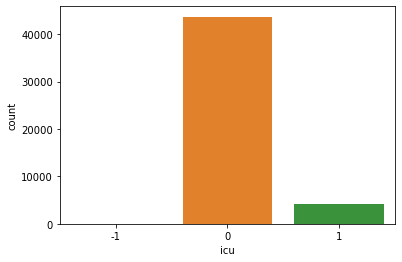

In [13]:
# Before we train we want to check the distribution of icu in the train set to ensure proper training
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='icu', data=train)

In [14]:
# The above graph indicates that the data is highly biased so we must perform some sampling to balance the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Over Sample the Minority Label to be 0.3 in proportion
over = SMOTE(sampling_strategy=0.3)
# Down Sample the Majority Label so that there are twice as many as minority
under = RandomUnderSampler(sampling_strategy=0.5)
# Pipeline to combine 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Sampled data
obs, results = pipeline.fit_resample(train[features], train['icu'])
obs = obs.fillna(0)

In [15]:
# Check if sampling has given the desired results
len(results[results == 0]), len(results[results == 1])

(26202, 13101)

**SMOTE Random Forest**

In [16]:
# Train Random Forest as a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
rf = RandomForestClassifier(n_estimators=40, max_depth=10).fit(obs, results)
print("Accuracy: {}".format(rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.9107657723696427
Precision: [0.95673337 0.47997973]
Recall: [0.94518059 0.54207212]
F-Score: [0.95092189 0.50913978]


**Normal Data Random Forest**

In [17]:
# Let us test for the non sampled dataset
rf_normal = RandomForestClassifier(n_estimators=40, max_depth=10).fit(train[features], train['icu'])
print("Accuracy: {}".format(rf_normal.score(test[features], test['icu'])))
metrics_normal = precision_recall_fscore_support(test['icu'], rf_normal.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics_normal[0], metrics_normal[1], metrics_normal[2]))

Accuracy: 0.9176562576357328
Precision: [0.92892762 0.55081967]
Recall: [0.98536012 0.19232971]
F-Score: [0.95631206 0.28510819]


**SMOTE & Training Functions**

In [18]:
# Lets repeat the procedure for "death" risk prediciton but with a function since that might help with the API implementation
def checkBinaryBalance(data, features, output, negative_label=0, positive_label=1):
    data_arr = np.array(data[output])
    if abs(data_arr[data_arr == negative_label]. shape[0] / len(data) - data_arr[data_arr == positive_label].shape[0] / len(data_arr)) > 0.4:
        print("Not Balanced returning sampled dataet.")
        # Over Sample the Minority Label to be 0.3 in proportion
        over = SMOTE(sampling_strategy=0.3)
        # Down Sample the Majority Label so that there are twice as many as minority
        under = RandomUnderSampler(sampling_strategy=0.5)
        # Pipeline to combine 
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # Sampled data
        obs, results = pipeline.fit_resample(data[features], data_arr)
        obs = obs.fillna(0)
        return obs, results
    print("Balanced dataset returning original.")
    obs = data[features]
    results = data_arr
    return obs, results

def randomForestEvaluation(obs, results, test_obs, test_results):
    rf = RandomForestClassifier(n_estimators=40, max_depth=10).fit(obs, results)
    print("Accuracy: {}".format(rf.score(test_obs, test_results)))
    metrics = precision_recall_fscore_support(test_results, rf.predict(test_obs))
    print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

**All sklearn-models**

In [19]:
# Now that we have trained on Random Forest Let us test the baselines for all classifiers within the sklearn library
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    #KNeighborsClassifier(2),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=20),
    MLPClassifier(max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
]

"""names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]"""
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

def allModelEvaluation(names, classifiers, obs, results, test_obs, test_results):
    scores = {}
    for name, clf in zip(names, classifiers):
        print("Training " + name)
        clf.fit(obs, results)
        train_score =  clf.score(obs, results)
        metrics_train = precision_recall_fscore_support(results, clf.predict(obs))
        test_score = clf.score(test_obs, test_results)
        metrics_test = precision_recall_fscore_support(test_results, clf.predict(test_obs))
        print("Train Accuracy: {}".format(train_score))
        print("Train Precision: {}\nTrain Recall: {}\nTrain F-Score: {}\n".format(metrics_train[0], metrics_train[1], metrics_train[2]))
        print("Test Accuracy: {}".format(test_score))
        print("Test Precision: {}\nTest Recall: {}\nTest F-Score: {}".format(metrics_test[0], metrics_test[1], metrics_test[2]))
        scores[name] = {'test accuracy' : test_score, 'test precision' : metrics_test[0], 'test recall': metrics_test[1], 'train accuracy' : train_score, 'train precision' : metrics_train[0], 'train recall' : metrics_train[1]}
        print("-----------")
    return scores

In [20]:
# Evaluate all models for "icu"
# Form train test
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)
sampled_icu_scores = allModelEvaluation(names, classifiers, obs, results, test[features], test['icu'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9696969696969697
Train Precision: [0.9613384  0.98827484]
Train Recall: [0.9945424  0.92000611]
Train F-Score: [0.97765856 0.95291932]

Test Accuracy: 0.8699115476714069
Test Precision: [0.93782044 0.28511038]
Test Recall: [0.9186792  0.34745278]
Test F-Score: [0.92815115 0.31320949]
-----------
Training Random Forest
Train Accuracy: 0.9673561814619749
Train Precision: [0.96621141 0.96978852]
Train Recall: [0.98549729 0.93107396]
Train F-Score: [0.97575906 0.950037  ]

Test Accuracy: 0.8822264575086742
Test Precision: [0.946153   0.34856099]
Test Recall: [0.92380851 0.43674871]
Test F-Score: [0.93484726 0.38770325]
-----------
Training Neural Net
Train Accuracy: 0.820929700022899
Train Precision: [0.8155295  0.83928372]
Train Recall: [0.94519502 0.57239905]
Train F-Score: [0.87558777 0.68061354]

Test Accuracy: 0.906660802423887
Test Precision: [0.95618893 0.46010768]
Test Recall: [0.94106647 0.53806525]
Te

**Hyper-parameter Optimization**

In [21]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'icu_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8879929629086645
Precision: [0.94683861 0.36930456]
Recall: [0.92973926 0.44075558]
F-Score: [0.93821103 0.40187891]


**Keras Fully-connected**

In [28]:
# Let us now train on a Dense Model in Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)

Not Balanced returning sampled dataet.


In [29]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=17))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
____________________________________________________

In [30]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("icu.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [31]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['icu'], test_size=0.5, shuffle=True, stratify=test['icu'])

In [32]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100
1185/1229 [===========================>..] - ETA: 0s - loss: 0.4892 - accuracy: 0.8059WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.91321, saving model to icu.h5
1229/1229 [==============================] - 1s 1ms/step - loss: 0.4897 - accuracy: 0.8055 - val_loss: 0.3715 - val_accuracy: 0.9132
Epoch 2/100
1226/1229 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.8139
Epoch 00002: val_accuracy did not improve from 0.91321
1229/1229 [==============================] - 1s 1ms/step - loss: 0.4733 - accuracy: 0.8138 - val_loss: 0.3427 - val_accuracy: 0.9132
Epoch 3/100
1174/1229 [===========================>..] - ETA: 0s - loss: 0.4697 - accuracy: 0.8135
Epoch 00003: val_accuracy improved from 0.91321 to 0.91341, saving model to icu.h5
1229/1229 [==============================] - 1

In [33]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("icu.h5") 
model.evaluate(test[features], test['icu'])

640/640 [==============================] - 0s 698us/step - loss: 0.3299 - accuracy: 0.9115


[0.32986608147621155, 0.9114987850189209]

In [34]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

320/320 [==============================] - 0s 703us/step - loss: 0.3318 - accuracy: 0.9096


[0.3317985534667969, 0.9095885157585144]

In [35]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test['icu'], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95662039 0.48360656]
Recall: [0.94614234 0.54035489]
F-Score: [0.95135251 0.51040822]


In [36]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95460916 0.47280335]
Recall: [0.94614234 0.51775487]
F-Score: [0.95035689 0.49425916]


## Lethality Predictions

In [37]:
# Form dataset with only death status known
lethal_res_known = covid_cases[covid_cases['lethal'] != -1]
lethal_res_known.shape

(220657, 21)

In [38]:
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])

In [39]:
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)

Not Balanced returning sampled dataet.


**Random Forest Evaluation**

In [40]:
# Evaluate Random Forest on training from the sampled dataset
randomForestEvaluation(obs, results, test[features], test['lethal'])

Accuracy: 0.8429861929363425
Precision: [0.976928   0.43041174]
Recall: [0.84084255 0.85828417]
F-Score: [0.90379133 0.57331691]


In [41]:
# Evaluate Rnadom forest on training form the original dataset
randomForestEvaluation(train[features], train['lethal'], test[features], test['lethal'])

Accuracy: 0.8931236593250551
Precision: [0.91062253 0.62898128]
Recall: [0.97371775 0.31796952]
F-Score: [0.9411138  0.42240183]


In [42]:
# Evaluate all models for "lethal"
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)
sampled_lethal_scores = allModelEvaluation(names, classifiers, obs, results, test[features], test['lethal'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9528402473631546
Train Precision: [0.95607912 0.94598395]
Train Recall: [0.97400472 0.91051129]
Train F-Score: [0.96495868 0.92790873]

Test Accuracy: 0.8562796459107526
Test Precision: [0.93202933 0.43118258]
Test Recall: [0.90191519 0.53060472]
Test F-Score: [0.91672502 0.4757549 ]
-----------
Training Random Forest
Train Accuracy: 0.9516427997309843
Train Precision: [0.96619833 0.9229889 ]
Train Recall: [0.96108705 0.93275429]
Train F-Score: [0.96363592 0.9278459 ]

Test Accuracy: 0.8585455753950271
Test Precision: [0.94348317 0.44563485]
Test Recall: [0.89216699 0.61860865]
Test F-Score: [0.9171078  0.51806485]
-----------
Training Neural Net
Train Accuracy: 0.8504174663320375
Train Precision: [0.92949207 0.73082629]
Train Recall: [0.83929187 0.87266867]
Train F-Score: [0.88209206 0.79547392]

Test Accuracy: 0.8406145200761352
Test Precision: [0.97721931 0.42645715]
Test Recall: [0.83781131 0.86061947]


In [43]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'lethal_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['lethal'])))
metrics = precision_recall_fscore_support(test['lethal'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8627602042357775
Precision: [0.95673014 0.4622844 ]
Recall: [0.88348662 0.71484759]
F-Score: [0.91865078 0.56147126]


In [44]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=17))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
____________________________________________________

In [45]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("lethal.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [46]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['lethal'], test_size=0.5, shuffle=True, stratify=test['lethal'])

In [47]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100
3782/3811 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8358
Epoch 00001: val_accuracy improved from -inf to 0.83655, saving model to lethal.h5
3811/3811 [==============================] - 6s 2ms/step - loss: 0.3490 - accuracy: 0.8359 - val_loss: 0.2812 - val_accuracy: 0.8366
Epoch 2/100
3803/3811 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8432
Epoch 00002: val_accuracy did not improve from 0.83655
3811/3811 [==============================] - 5s 1ms/step - loss: 0.3344 - accuracy: 0.8432 - val_loss: 0.2986 - val_accuracy: 0.8317
Epoch 3/100
3804/3811 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8450
Epoch 00003: val_accuracy improved from 0.83655 to 0.85314, saving model to lethal.h5
3811/3811 [==============================] - 5s 1ms/step - loss: 0.3326 - accuracy: 0.8451 - val_loss: 0.2666 - val_accuracy: 0.8531
Epoch 4/100
3778/3811 [============================>.] - ETA: 0s - loss: 0.3317 

In [48]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("lethal.h5") 
model.evaluate(test[features], test["lethal"])

2069/2069 [==============================] - 1s 696us/step - loss: 0.2679 - accuracy: 0.8517


[0.26790866255760193, 0.8516873717308044]

In [49]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

1035/1035 [==============================] - 1s 631us/step - loss: 0.2692 - accuracy: 0.8502


[0.2692146599292755, 0.8502371907234192]

In [50]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test["lethal"], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.97148274 0.44406757]
Recall: [0.85603321 0.82067355]
F-Score: [0.91011133 0.57629898]


In [51]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.97045259 0.44083588]
Recall: [0.85529262 0.81415929]
F-Score: [0.90924071 0.57197133]
